In [30]:
from ipstartup import *
croot = "c:" if os.name=="nt" else "/mnt/c"
droot = "d:" if os.name=="nt" else "/mnt/d"
os.chdir(f"{droot}/data1")
sys.path.append(f"{croot}/Users/simon/OneDrive/Documents/py/live/slab/src")
############################################################################
from transformers import pipeline
import numpy as np
import pandas as pd
from model.utils import *

# feature_extraction => sents,bs=1,tokens,features=768
model = "nbroad/ESG-BERT"
pipe = pipeline('feature-extraction', model=model)

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)
Some weights of the model checkpoint at nbroad/ESG-BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


time: 10.9 s


In [31]:
# load data
sents = pd.read_csv("Clean_sentences.csv").Sentences.tolist()
sents = [s.replace("_"," ") for s in sents]
sents = Document(sents, pipe)
kpis = pd.read_excel("SustainLab_Generic_Granular_KPI list.xlsx", sheet_name="Granular KPI list").KPI.tolist()
kpis = Document(kpis, pipe)

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)


time: 179 ms


In [32]:
# get features
sents.get_feats()
kpis.get_feats()

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

time: 31.2 s


# sentence embedding

In [33]:
# sentence embedding
sentdf = sents.compare_sents(kpis)
sentdf.sample(3)

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


,kpi,score
sent,,
"the timer lowers the indoor temperature when no one is present, eliminating wasteful use by floor, thereby achieving about a 30% reduction in energy consumption as compared to an ordinary central air conditioning system.",total heating energy sold,0.832714
"in addition to these benefits, an lca we conducted determined that hp instant ink on average decreases the carbon footprint of ink purchase and distribution by 73%, while reducing energy use by 69% and lowering water use by 70%, compared with cartridge purchase and recycling through traditional 84 hp 2020 sustainable impact report footprint integrity and human rights retail channels.",total fuel consumption from renewable sources,0.702736
"manufacturing although accounting for a small portion of our total lifecycle emissions, electrolux has reduced the energy use per product by 45% since 2005.",Total weight or volume of non-renewable materi...,0.732722


time: 16.5 ms


# ngram embedding

In [34]:
# inspect ngram embedding dataframe on a sentence
# note ngrams are within the context of the sentence. "energy" has different embeddings in different sentences.
i = np.random.randint(len(sents.sents))
ngram, kpi, score, ngramdf1 = sents.compare_ngrams(i, kpis, 5)
sent = pipe.tokenizer.decode(pipe.tokenizer.encode(sents.sents[i]))
print(i, sent)
ngramdf1[:10]

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


39 [CLS] in 2020, our solar energy consumption increased from 1 % to 3 %, helping us save 7, 408 mwh. [SEP]


,best,score
ngram,,
our solar energy consumption increased,amount of energy consumption reduced,0.921617
mwh. [SEP],amount of energy consumption reduced,0.920483
our solar energy consumption,amount of energy consumption reduced,0.920439
", our solar energy consumption",amount of energy consumption reduced,0.919891
solar energy consumption increased,amount of energy consumption reduced,0.919180
##h. [SEP],amount of energy consumption reduced,0.918977
consumption,amount of energy consumption reduced,0.917295
solar energy consumption,amount of energy consumption reduced,0.917209
"2020, our solar energy",amount of energy consumption reduced,0.916838


time: 78.6 ms


In [35]:
# ngrams for all sentences
res = []
for i, sent in enumerate(tqdm(sents.sents)):
    ngram, kpi, score, _ = sents.compare_ngrams(i, kpis)
    res.append([sent, ngram, kpi, score])
ngramdf = pd.DataFrame(res, columns=["sent", "ngram", "kpi", "score"])
ngramdf = ngramdf.set_index("sent")

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

time: 52.9 s


[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


<AxesSubplot:>

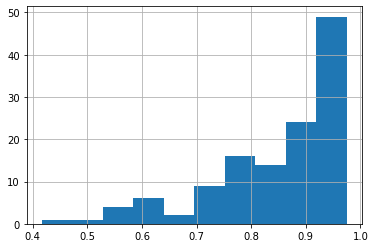

time: 344 ms


In [36]:
ngramdf.score.hist()

In [59]:
out = ngramdf.join(sentdf, rsuffix="_sent")[["ngram", "kpi", "score", "kpi_sent", "score_sent"]]
out.to_excel("sent_ngram.xlsx")
np.random.seed(0)

[cellevents:43:INFO]:starting (time=Jul-08 10:05 MainProcess)


time: 70.2 ms


In [60]:
out[out.score>.9].sample(5)

[cellevents:43:INFO]:starting (time=Jul-08 10:05 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
"to achieve zero carbon monozukuri, we acquired sbt certification, an international initiative for greenhouse gas emissions reduction, to be consistent with the paris agreements 2c temperature target.",zero carbon,gross market GHG emissions of CO2 equivalent,0.927865,co2 equivalent of GHG emissions reduced,0.912248
"resource efficiency in 2020, we continued to improve our energy efficiency per oroduct by 1.4% compared with the previous year despite the coronavirus pandemic.",[CLS] resource efficiency,total cooling energy consumption,0.905427,energy consumption outside of the organization,0.876487
"water scarcity levels are rising-14 out of 20 of the worlds largest cities are already experiencing inadequate supplies and two-thirds of the worlds population are expected to live in water-stressed areas by 2025. still, the average daily water consumption per person is up to 500 liters in some developed countries and approximately 16% of energy consumption in the home is related to water usage.",water usage.,total water consumption with water stress,0.956143,total water withdrawal in megaliters,0.944818
"in our group, ghg emissions derived from our business activities are as low as 1.3% for scopes 1 and 2 and our scope 3 emissions (indirect emissions from sources other than our company) account for the majority of 98.7%.",", ghg",Scope 1 GHG emissions of CO2 equivalent,0.951311,co2 equivalent of GHG emissions reduced,0.930687
data was based on those in 2019. the company intends to reduce the rate of both direct and indirect greenhouse gas emission (scope 1&2) per employee by 10%.,and indirect greenhouse gas emission (,co2 equivalent of GHG emissions reduced,0.922434,co2 equivalent of GHG emissions reduced,0.916171


time: 17.2 ms


In [61]:
out[out.score<.8].sample(5)

[cellevents:43:INFO]:starting (time=Jul-08 10:05 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
"manufacturing although accounting for a small portion of our total lifecycle emissions, electrolux has reduced the energy use per product by 45% since 2005.",[CLS] manufacturing although,Total weight or volume of non-renewable materi...,0.737284,Total weight or volume of non-renewable materi...,0.732722
"energy efficiency and greenhouse gas reduction approximately 85% of the energy consumed during the multi-decade lifecycle of a homeincluding the initial raw material extraction, manufacturing, and constructioncomes from the day-to-day living in it.",.,gross market GHG emissions of CO2 equivalent,0.750007,ratio of energy intensity of the organization,0.683441
"our grohe production plant in lahr, southwest germany, has replaced two inefficient boilers with a cogeneration system,* contributing to an annual co, emissions reduction of 2,550 metric tons.",##ficient boilers,total heating energy sold,0.709671,total steam consumption,0.687859
"a forest plantation managed by new forests in australia our company-owned forests, mitsuis forests, absorb and fixate 160,000 tons of carbon dioxide annually it is estimated that the carbon dioxide absorbed and fixated by mitsuis forests amounts to approximately 160,000 tons per year, and co2 accumulation has reached approximately 10 million tons*'.",co2,co2 equivalent of biogenic co2 emissions,0.777837,co2 equivalent of GHG emissions reduced,0.678101
"for the 2020-2024 period, the company has set itself the new challenge of increasing its installed capacity by nearly 50%, adding 5,000 renewable mw to its current figures.",[CLS],ratio of energy intensity of the organization,0.782985,ratio of energy intensity of the organization,0.756949


time: 17 ms


In [62]:
out[out.kpi!=out.kpi_sent].sample(5)

[cellevents:43:INFO]:starting (time=Jul-08 10:05 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
"as a result of promoting energy conservation and increasing the use of renewable energy including these efforts, we achieved a 32% greenhouse gas emissions reduction per unit of sales in fiscal 2019 from fiscal 2015, at a faster pace than the paris agreements 2c temperature target.",[CLS],gross market GHG emissions of CO2 equivalent,0.908107,Scope 2 GHG emissions of CO2 equivalent,0.884262
"se 00 ee 07 es 003 @ electricity consumption per kg of waste treated (kwh/kg) the increase observed in the average consumption per 100 km is due to the fact that in 2020, new and more de- manding routes were added for sterilisation s.a.",of waste treated (,particulate matter,0.543269,persistent organic pollutants,0.527370
"this helps our customers reduce consumption of 45% in desktops, 46% in energy use in their homes and offices.",offices. [SEP],energy consumption outside of the organization,0.939033,amount of energy consumption reduced,0.934773
"we also converted to 100% renewable energy at the lixil headquarters, kyoto showroom, and inax museums, achieving an annual carbon reduction of 2,000 metric tons.",metric tons. [SEP],energy consumption outside of the organization,0.862242,ratio of energy intensity of the organization,0.848135
"brownfield site redevelopment may lead to a net ghg reduction of 51.9 mt co, eq.",ghg reduction of 51,gross market GHG emissions of CO2 equivalent,0.937558,Scope 1 GHG emissions of CO2 equivalent,0.933299


time: 15.6 ms
